# T09P01 - MdSM

# CASO DE ESTUDIO 1: Tiempo crítico de despeje de una falta trifásica al comienzo de la línea y que se despeja por apertura de la misma.

## Enunciado

Determine el tiempo crítico de despeje de una falta trifásica al comienzo de una línea y que se despeja por apertura de la misma.

Tome como datos:

- Potencia nominal del generador ($S_g$): 100 MVA.
- Tensión nominal en bornes del generador ($U_g$): 15 kV.
- Constante de inercia del generador ($H_g$): 3 s (Referida a la potencia del generador).
- Carga del generador previa a la falta: 100% potencia nominal.
- Factor de potencia del generador previo a la falta: $0.8$ inductivo.
- Reactancia transitoria del generador ($X'_g$): 0.3 pu.
- Potencia del transformador ($S_t$): 100 MVA.
- Reactancia de cc del transformador ($X_t$): 0.15 pu.
- Reactancia de la línea ($X_l$): 0.10 pu.
- Tensión del nudo de conexión ($U_{red}$): 220 kV.
- Potencia del nudo de conexión ($S_{red}$): infinita.

**Sistema eléctrico:**

<img src="./Figs/T09P01_Fig00.png" width=95%>

## Resolución

In [1]:
# Importar librerías genéricas:
import numpy as np
import cmath as cm
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import scipy.integrate as integrate
import scipy.optimize as optim

# Formato general de salida de resultados numéricos:
np.set_printoptions(precision=3, suppress=True)

### Datos del problema

In [2]:
# Datos:
Sgen = 100 # MVA
Ugen = 15 # kV
H = 3 # s
Xgen = 0.3 # pu (transitoria)
Ured = 220 # kV
St = 100 # MVA
Xt = 0.15 # pu
Xl = 0.10 # pu
FPgen = 0.8 # factor de potencia del generador
Gen = 1 # Régimen de carga del generador (tanto por uno)
f = 50 # Hz
omega_0 = 2*np.pi*f # Velocidad de sincronismo

### Transformación a valores por unidad

In [3]:
# Magnitudes base:
Sbase = 100 # Potencia base.
Ub1 = Ugen # Tensión base zona 1 (generador).
Ub2 = Ured # Tensión base zona 2 (red).

# Magnitudes transformadas:
ugen = Ugen/Ub1 # Tensión del generador.
ured = Ured/Ub2 # Tensión de red.
sgen = Sgen/Sbase # Potencia entregada por el generador pre-falta.
H = H*Sgen/Sbase # Constante de inercia referida a la potencia base del sistema.

### Condiciones pre-falta

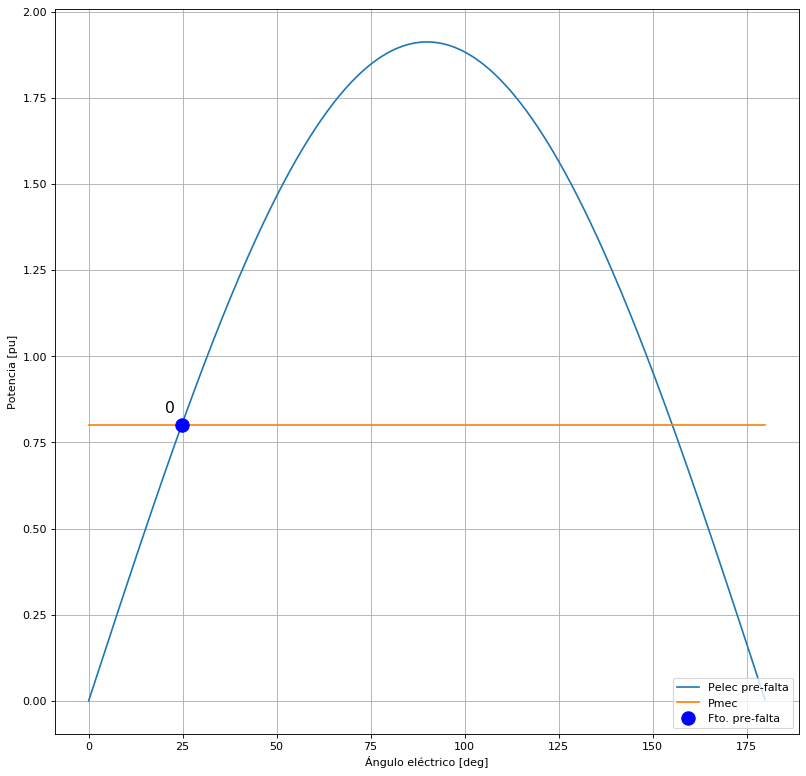

In [4]:
# Corriente inyectada por el generador antes de la falta:
sgen_comp = sgen*Gen*(FPgen+cm.sin(np.arccos(FPgen))*1j) # Potencia compleja entregada por el generador.
igen = sgen_comp.conjugate()/ugen.conjugate() # Corriente inyectada pre-falta.

# Tensión detrás de la reactancia transitoria del generador respecto de los bornes del mismo:
egen = ugen+Xgen*1j*igen 

# Tensión del nodo de conexión a red respecto de los bornes del generador:
ured = ugen-(Xt+Xl)*1j*igen

# Ángulo relativo de la tensión detrás de la reactancia transitoria del generador con relación a la tensión del nudo de potencia infinita ANTES DE LA FALTA:
delta_0 = cm.phase(egen)-cm.phase(ured) # Ángulo de fase en sincronismo [rad].
delta_0_deg = delta_0*180/np.pi # [deg].

# Potencia eléctrica:
delta = np.arange(0,np.pi,0.01)
delta_deg = delta*180/np.pi
pelec = abs(egen)*abs(ured)*np.sin(delta)/(Xgen+Xt+Xl)

# Representación gráfica
anotaciones = True
fig = plt.figure(figsize=(12,12),dpi= 80)
plt.grid() # Malla.
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

# Curva de potencia eléctrica pre-falta:
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
pmec = sgen_comp.real*np.ones(np.size(delta))
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')

# Punto de operación antes de la falta:
p1x = delta_0*180/np.pi
p1y = sgen_comp.real
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. pre-falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.05, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')

# Leyenda del gráfico:
plt.legend(loc = 'lower right')
plt.show()

### Sistema en falta (apertura de la línea)

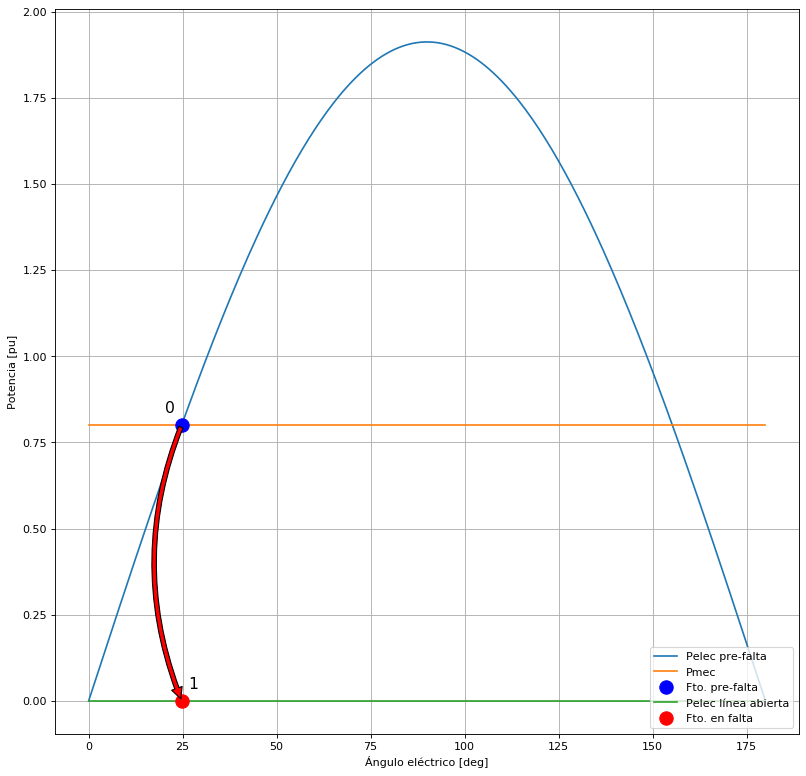

In [5]:
# Representación gráfica:
anotaciones = True
fig2 = plt.figure(figsize=(12,12),dpi= 80)
plt.grid()
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

# Curva de potencia eléctrica pre-falta:
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')

# Punto de operación antes de la falta:
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. pre-falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.05, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')

# Curva de potencia eléctrica durante el tiempo de despeje de la falta:
pelec2 = np.zeros(np.size(delta))
fpelec2 = plt.plot(delta_deg, pelec2, label = 'Pelec línea abierta')

# Operación en falta:
p2x = p1x
p2y = 0
p2 = plt.plot([p2x], [p2y], 'ro', markersize=12, label = 'Fto. en falta')
## Anotaciones:
if anotaciones:
    plt.text (p2x+3, p2y+0.05, '1', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p1x, 0), xytext=(p1x, p1y), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))

# Leyenda del gráfico:
plt.legend(loc = 'lower right')
plt.show()

### Evolución del ángulo eléctrico con el tiempo

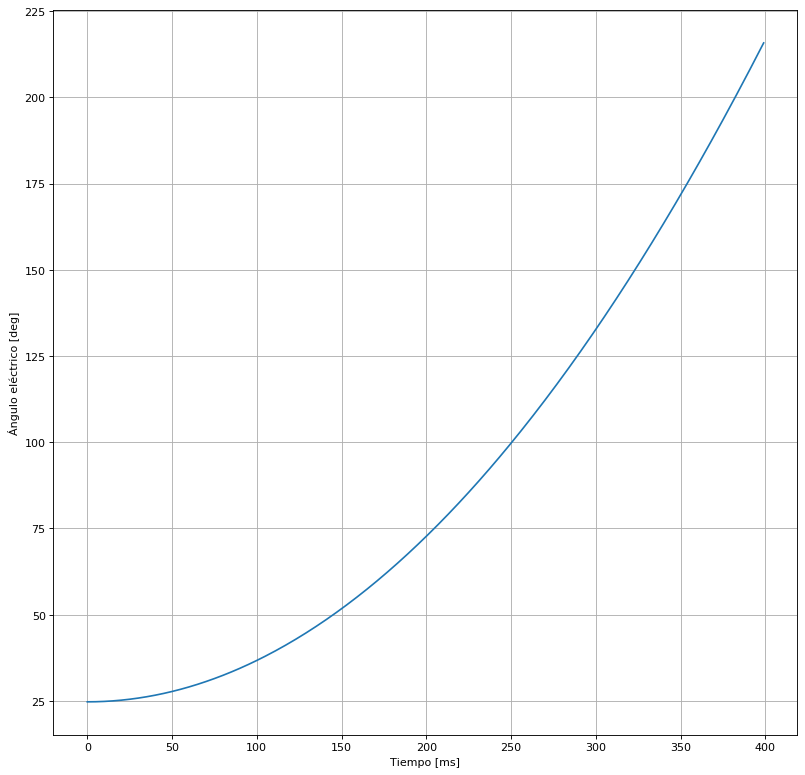

In [6]:
t = np.arange(0,0.4,0.001) # Tiempo [s].
delta_t = (omega_0*sgen_comp.real*t**2/(4*H)+delta_0)*180/np.pi # Ángulo eléctrico para cada instante t [deg].

# Representación gráfica:
fig3 = plt.figure(figsize=(12,12),dpi= 80)
plt.grid()
plt.ylabel('Ángulo eléctrico [deg]')
plt.xlabel('Tiempo [ms]')

plt.plot(1000*t, delta_t)

plt.show()

### Áreas aceleradoras y deceleradora máxima

In [7]:
# Ángulo de despeje de la falta = cierre del interruptor:
delta_desp_deg = 65 # [deg].
delta_desp = delta_desp_deg*np.pi/180 # [rad].

# Ángulo máximo para el área decelerdora:
delta_max = np.pi-delta_0 # [rad].
delta_max_deg = delta_max*180/np.pi # [deg].

# Cálculo del área aceleradora:
## Potencia aceleradora en función del ángulo eléctrico:
def Pacel(delta,sgen_comp):
    pacel = sgen_comp.real
    return pacel

## Área aceleradora:
def Aacel(delta_1,delta_2):
    aacel = integrate.quad(Pacel, delta_1, delta_2, args=(sgen_comp))
    return aacel[0]

Area_acel = Aacel(delta_0, delta_desp)
print('Área aceleradora: {:.4} pu.'.format(Area_acel))

# Cálculo del área deceleradora máxima:
## Potencia deceleradora en función del ángulo eléctrico:
def Pdecel(delta,egen,ured,Xgen,Xt,Xl,sgen_comp):
    pdecel = abs(egen)*abs(ured)*np.sin(delta)/(Xgen+Xt+Xl)-sgen_comp.real
    return pdecel

## Área deceleradora máxima:
def Adecel(delta_1,delta_2):
    adecel = integrate.quad(Pdecel, delta_1, delta_2, args=(egen,ured,Xgen,Xt,Xl,sgen_comp))
    return adecel[0]

Area_decel_max = Adecel(delta_desp, delta_max)
print('Área deceleradora máxima: {:.4} pu.'.format(Area_decel_max))

Área aceleradora: 0.5622 pu.
Área deceleradora máxima: 1.284 pu.


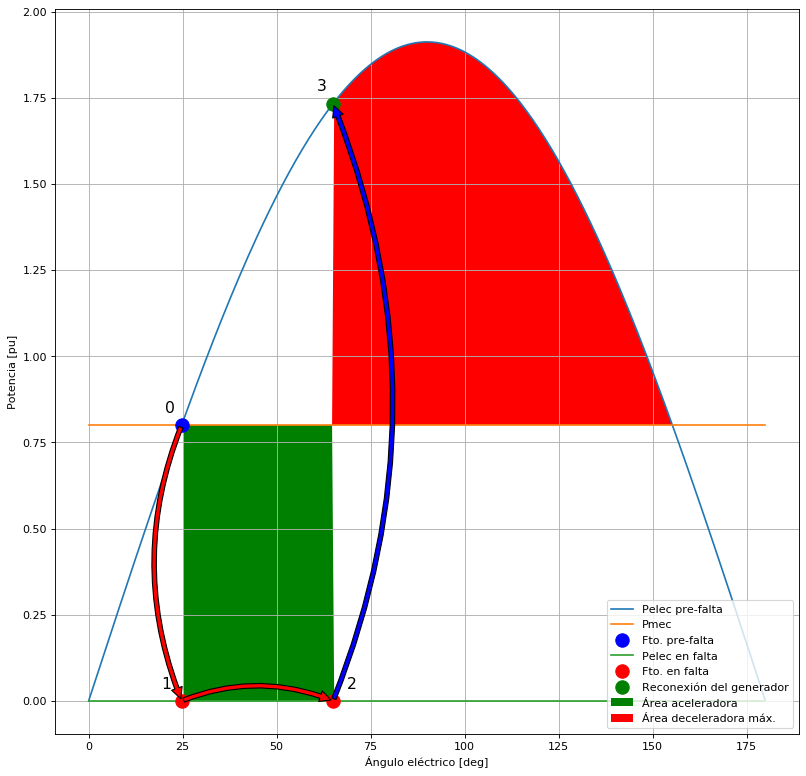

In [8]:
# Representación gráfica
anotaciones = True
fig4 = plt.figure(figsize=(12,12),dpi= 80)
plt.grid()
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

# Curva de potencia eléctrica pre-falta:
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')

# Punto de operación antes de la falta:
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. pre-falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.05, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')


# Curva de potencia eléctrica durante el tiempo de despeje de la falta:
fpelec2 = plt.plot(delta_deg, pelec2, label = 'Pelec en falta')

# Operación en falta:
p2x = np.array([delta_0_deg,delta_desp_deg])
p2y = np.array([0,0])
p2 = plt.plot(p2x, p2y, 'ro', markersize=12, label = 'Fto. en falta')
## Anotaciones:
if anotaciones:
    plt.text (p2x[0]-4, p2y[0]+0.05, '1', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[0], 0), xytext=(p1x, p1y), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))
    plt.annotate("", xy=(p2x[1], p2y[1]), xytext=(p2x[0], p2y[0]), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))

# Reconexión:
p3x = delta_desp_deg
p3y = abs(egen)*abs(ured)*np.sin(delta_desp)/(Xgen+Xt+Xl)
p3 = plt.plot([p3x], [p3y], 'go', markersize=12, label = 'Reconexión del generador')
## Anotaciones:
if anotaciones:
    plt.text (p3x+5, 0+0.05, '2', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.text (p3x-3, p3y+0.05, '3', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p3x, p3y), xytext=(p2x[1], p2y[1]), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))

# Área aceleradora:
delta_deg2 = np.ma.masked_greater(delta_deg,p2x[1])
plt.fill_between(delta_deg2, 0, pmec, where = pelec >= pmec, facecolor='green', interpolate=True, label='Área aceleradora')

# Área deceleradora máxima:
delta_deg3 = np.ma.masked_greater(delta_deg, delta_max*180/np.pi)
plt.fill_between(delta_deg3, pmec, pelec, where = delta_deg3 >= p2x[1], facecolor='red', interpolate=True, label='Área deceleradora máx.')

plt.legend(loc = 'lower right')
plt.show()

Al ser el área aceleradora menor que el área deceleradora, el sistema podrá alcanzar la estabilidad y el desplazamiento máximo del ángulo será menor que el ángulo máximo:

$$\delta_{max}\leq \pi-\delta_0.$$

### Ángulo de oscilación máximo

In [9]:
# Función del residuo de la diferencia de áreas aceleradora y deceleradora en función del ángulo de reconexión delta:
def IgualdadAreas(delta):
    return (Aacel(delta_0,delta_desp)-Adecel(delta_desp,delta))**2

# Comenzamos la optimización: función residuo de la diferencia de áreas mínima:
delta_start = (delta_0+delta_max)/2 # Valor semilla.
bnd_x1 = 1.001*delta_0 # Límite inferior (restricción).
bnd_x2 = delta_max # Límite superior (restricción).
limites = optim.Bounds(bnd_x1,bnd_x2)
delta_opt = optim.minimize(IgualdadAreas,np.array([delta_start]),method='L-BFGS-B',bounds=limites).x
delta_1 = delta_opt[0] # [rad].
delta_1_deg = delta_1*180/np.pi # [deg].
print('El ángulo de oscilación máximo es: {:.4f} deg'.format(delta_1_deg))

El ángulo de oscilación máximo es: 95.3357 deg


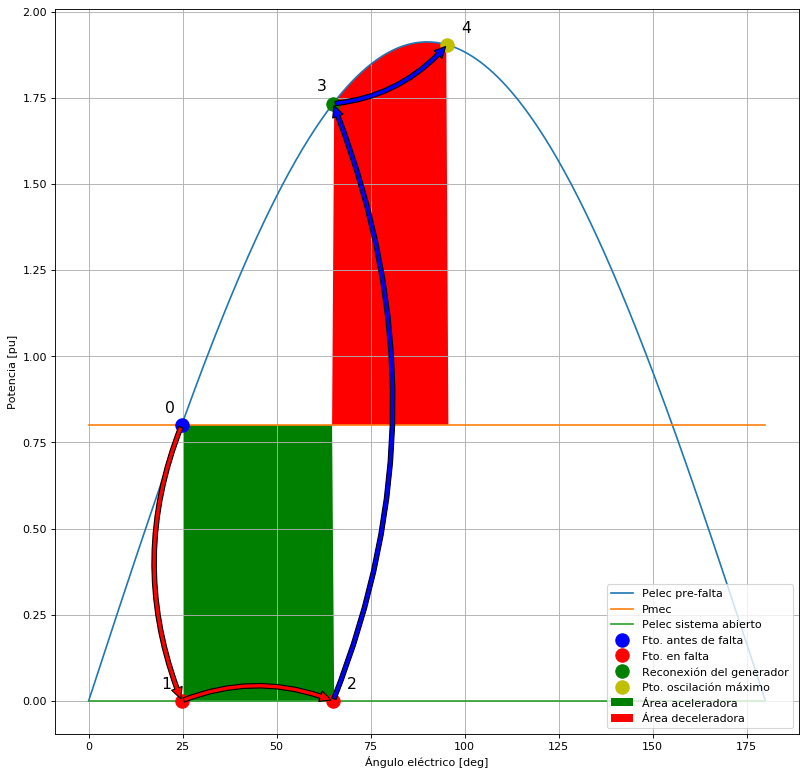

In [10]:
# Representación gráfica:
anotaciones = True
fig5 = plt.figure(figsize=(12,12),dpi= 80)
plt.grid()
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

# Curva de potencia eléctrica pre-falta:
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')

# Curva de potencia eléctrica durante el tiempo de despeje de la falta:
fpelec2 = plt.plot(delta_deg, pelec2, label = 'Pelec sistema abierto')

# Punto de operación pre-falta:
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. antes de falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.05, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')

# Operación en falta hasta el punto de despeje:
p2 = plt.plot(p2x, p2y, 'ro', markersize=12, label = 'Fto. en falta')
## Anotaciones:
if anotaciones:
    plt.text (p2x[0]-4, p2y[0]+0.05, '1', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[0], 0), xytext=(p1x, p1y), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))
    plt.annotate("", xy=(p2x[1], p2y[1]), xytext=(p2x[0], p2y[0]), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))

# Reconexión:
p3 = plt.plot([p3x], [p3y], 'go', markersize=12, label = 'Reconexión del generador')
## Anotaciones:
if anotaciones:
    plt.text (p3x+5, 0+0.05, '2', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.text (p3x-3, p3y+0.05, '3', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p3x, p3y), xytext=(p2x[1], p2y[1]), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))

# Punto de oscilación máximo:
p4x = delta_1_deg
p4y = abs(egen)*abs(ured)*np.sin(delta_1)/(Xgen+Xt+Xl)
p4 = plt.plot([p4x], [p4y], 'yo', markersize=12, label = 'Pto. oscilación máximo')
## Anotaciones:
if anotaciones:
    plt.text (p4x+5, p4y+0.05, '4', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p4x, p4y), xytext=(p3x, p3y), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))

# Área aceleradora:
delta_deg2 = np.ma.masked_greater(delta_deg,delta_desp_deg)
plt.fill_between(delta_deg2, 0, pmec, where = pelec >= pmec, facecolor='green', interpolate=True, label='Área aceleradora')

# Área deceleradora:
delta_deg3 = np.ma.masked_greater(delta_deg, delta_1_deg)
plt.fill_between(delta_deg3, pmec, pelec, where = delta_deg3 >= delta_desp_deg, facecolor='red', interpolate=True, label='Área deceleradora')

plt.legend(loc = 'lower right')
plt.show()

### Cálculo del ángulo y tiempo críticos

In [11]:
# Cálculo del ángulo crítico de despeje de la falta:
## Mediante fórmula:
delta_cri = np.arccos(np.sin(delta_0)*(np.pi-2*delta_0)-np.cos(delta_0))
delta_cri_deg = delta_cri*180/np.pi
print('Ángulo crítico de despeje de la falta (fórmula): {:.2f} deg.'.format(delta_cri_deg))

## Mediante cálculo numérico:
# Función del residuo de la diferencia de áreas aceleradora y deceleradora máxima en función del ángulo de reconexión delta:
def IgualdadAreas2(delta):
    return (Aacel(delta_0,delta)-Adecel(delta,delta_max))**2

# Comenzamos la optimización: función residuo de la diferencia de áreas mínima:
delta_start = (delta_0+delta_max)/2 # Valor semilla.
bnd_x1 = delta_0 # Límite inferior (restricción).
bnd_x2 = delta_max # Límite superior (restricción).
limites = optim.Bounds(bnd_x1,bnd_x2)
delta_opt = optim.minimize(IgualdadAreas2,np.array([delta_start]),method='L-BFGS-B',bounds=limites).x
delta_cri2 = delta_opt[0] # [rad].
delta_cri2_deg = delta_cri2*180/np.pi # [deg].
print('Ángulo crítico de despeje de la falta (método numérico): {:.2f} deg.'.format(delta_cri2_deg))

# Cálculo del tiempo crítico de despeje de la falta:
Pacel = sgen_comp.real
t_cri = (4*H*(delta_cri-delta_0)/(omega_0*Pacel))**0.5
print('Tiempo crítico de despeje de la falta: {:.4} s.'.format(t_cri))

Ángulo crítico de despeje de la falta (fórmula): 87.42 deg.
Ángulo crítico de despeje de la falta (método numérico): 87.42 deg.
Tiempo crítico de despeje de la falta: 0.2285 s.


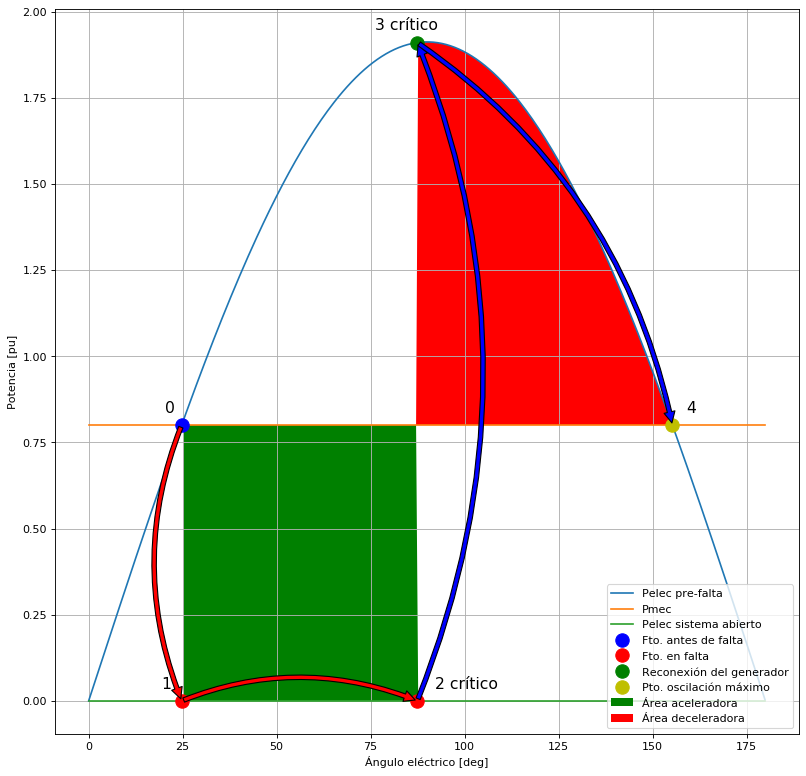

In [12]:
# Representación gráfica:
anotaciones = True
fig6 = plt.figure(figsize=(12,12),dpi= 80)
plt.grid()
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

# Curva de potencia eléctrica pre-falta:
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')

# Curva de potencia eléctrica durante el tiempo de despeje de la falta:
fpelec2 = plt.plot(delta_deg, pelec2, label = 'Pelec sistema abierto')

# Punto de operación pre-falta:
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. antes de falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.05, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')

# Operación en falta hasta el punto de despeje crítico:
p2x = np.array([delta_0_deg,delta_cri_deg])
p2y = np.array([0,0])
p2 = plt.plot(p2x, p2y, 'ro', markersize=12, label = 'Fto. en falta')
## Anotaciones:
if anotaciones:
    plt.text (p2x[0]-4, p2y[0]+0.05, '1', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[0], 0), xytext=(p1x, p1y), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))
    plt.annotate("", xy=(p2x[1], p2y[1]), xytext=(p2x[0], p2y[0]), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))

# Reconexión:
p3x = delta_cri_deg
p3y = abs(egen)*abs(ured)*np.sin(delta_cri)/(Xgen+Xt+Xl)
p3 = plt.plot([p3x], [p3y], 'go', markersize=12, label = 'Reconexión del generador')
## Anotaciones:
if anotaciones:
    plt.text (p3x+13, 0+0.05, '2 crítico', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.text (p3x-3, p3y+0.05, '3 crítico', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p3x, p3y), xytext=(p2x[1], p2y[1]), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))

# Punto de oscilación máximo:
p4x = delta_max_deg
p4y = abs(egen)*abs(ured)*np.sin(delta_max)/(Xgen+Xt+Xl)
p4 = plt.plot([p4x], [p4y], 'yo', markersize=12, label = 'Pto. oscilación máximo')
## Anotaciones:
if anotaciones:
    plt.text (p4x+5, p4y+0.05, '4', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p4x, p4y), xytext=(p3x, p3y), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))

# Área aceleradora:
delta_deg2 = np.ma.masked_greater(delta_deg,delta_cri_deg)
plt.fill_between(delta_deg2, 0, pmec, where = pelec >= pmec, facecolor='green', interpolate=True, label='Área aceleradora')

# Área deceleradora:
delta_deg3 = np.ma.masked_greater(delta_deg, delta_max_deg)
plt.fill_between(delta_deg3, pmec, pelec, where = delta_deg3 >= delta_cri_deg, facecolor='red', interpolate=True, label='Área deceleradora')

plt.legend(loc = 'lower right')
plt.show()

### Oscilación debida al nuevo desequilibrio Pelec > Pmec

Salvo que se despejara la falta justo en el ángulo crítico y, por lo tanto, el ángulo de oscilación máximo fuera $\delta_{max}=\pi-\delta_0$, caso en el que se encontraría un nuevo equilibrio al cumplirse en dicho punto de funcionamiento que $P_{elec}=P_{mec}$, el sistema aunque haya alcanzado la oscilación máxima (igualdad de áreas = igualdad de energía de aceleración y deceleración), estaría en desequilibrio ($P_{elec}>P_{mec}$) por lo que volvería a oscilar en sentido inverso.

In [13]:
# Cálculo del área deceleradora:
Area_decel_2 = Adecel(delta_0, delta_1)
print('Área deceleradora 2: {:.4} pu.'.format(Area_decel_2))

# Potencia aceleradora en función del ángulo eléctrico (Pelec != 0):
def Pacel2(delta,sgen_comp,egen,ured,Xgen,Xt,Xl):
    pacel = sgen_comp.real-abs(egen)*abs(ured)*np.sin(delta)/(Xgen+Xt+Xl)
    return pacel

## Área aceleradora 2:
def Aacel2(delta_1,delta_2):
    aacel2 = integrate.quad(Pacel2, delta_1, delta_2, args=(sgen_comp,egen,ured,Xgen,Xt,Xl))
    return aacel2[0]

# Función del residuo de la diferencia de áreas aceleradora y deceleradora en función del ángulo delta:
def IgualdadAreas3(delta):
    return (Aacel2(delta,delta_0)-Adecel(delta_0,delta_1))**2

# Comenzamos la optimización: función residuo de la diferencia de áreas mínima:
delta_start = (delta_0-delta_max)/2 # Valor semilla.
bnd_x1 = -delta_max # Límite inferior (restricción).
bnd_x2 = 0.99*delta_0 # Límite superior (restricción).
limites = optim.Bounds(bnd_x1,bnd_x2)
delta_opt2 = optim.minimize(IgualdadAreas3,np.array([delta_start]),method='L-BFGS-B',bounds=limites).x
delta_2 = delta_opt2[0] # [rad].
delta_2_deg = delta_2*180/np.pi # [deg].
print('El ángulo de oscilación máximo 2 es: {:.4f} deg'.format(delta_2_deg))

Área deceleradora 2: 0.9284 pu.
El ángulo de oscilación máximo 2 es: -32.6643 deg


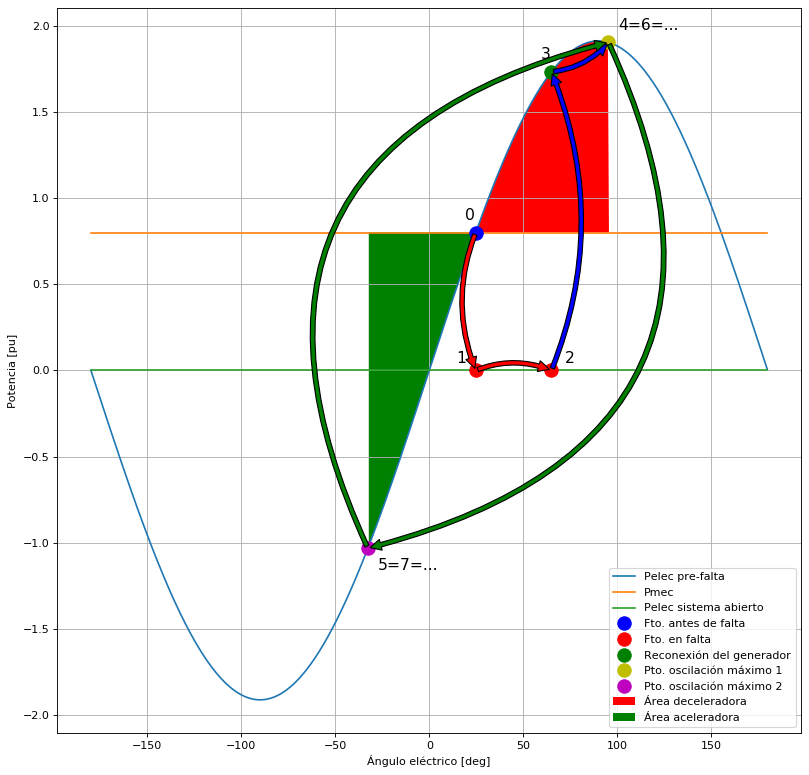

In [14]:
# Representación gráfica:
anotaciones = True
fig7 = plt.figure(figsize=(12,12),dpi= 80)
plt.grid()
plt.ylabel('Potencia [pu]')
plt.xlabel('Ángulo eléctrico [deg]')

delta = np.arange(-1*np.pi,np.pi,0.01)
delta_deg = delta*180/np.pi

# Curva de potencia eléctrica pre-falta:
pelec = abs(egen)*abs(ured)*np.sin(delta)/(Xgen+Xt+Xl)
fpelec = plt.plot(delta_deg, pelec, label = 'Pelec pre-falta')

# Curva de potencia mecánica:
pmec = sgen_comp.real*np.ones(np.size(delta))
fpmec = plt.plot(delta_deg, pmec, label = 'Pmec')

# Curva de potencia eléctrica durante el tiempo de despeje de la falta:
pelec2 = np.zeros(np.size(delta))
fpelec2 = plt.plot(delta_deg, pelec2, label = 'Pelec sistema abierto')

# Punto de operación pre-falta:
p1 = plt.plot([p1x], [p1y], 'bo', markersize=12, label = 'Fto. antes de falta')
## Anotaciones:
if anotaciones:
    plt.text (p1x-3, p1y+0.1, '0', fontsize=14, horizontalalignment='center', verticalalignment='center')

# Operación en falta hasta el punto de despeje:
p2x = np.array([delta_0_deg,delta_desp_deg])
p2y = np.array([0,0])
p2 = plt.plot(p2x, p2y, 'ro', markersize=12, label = 'Fto. en falta')
## Anotaciones:
if anotaciones:
    plt.text (p2x[0]-8, p2y[0]+0.07, '1', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p2x[0], 0), xytext=(p1x, p1y), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))
    plt.annotate("", xy=(p2x[1], p2y[1]), xytext=(p2x[0], p2y[0]), size=20, va="center", ha="center", arrowprops=dict(facecolor='red',arrowstyle="simple",connectionstyle="arc3,rad=-0.2"))

# Reconexión:
p3x = delta_desp_deg
p3y = abs(egen)*abs(ured)*np.sin(delta_desp)/(Xgen+Xt+Xl)
p3 = plt.plot([p3x], [p3y], 'go', markersize=12, label = 'Reconexión del generador')
## Anotaciones:
if anotaciones:
    plt.text (p3x+10, 0+0.07, '2', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.text (p3x-3, p3y+0.1, '3', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.annotate("", xy=(p3x, p3y), xytext=(p2x[1], p2y[1]), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))

# Punto de oscilación máximo 1:
p4x = delta_1_deg
p4y = abs(egen)*abs(ured)*np.sin(delta_1)/(Xgen+Xt+Xl)
p4 = plt.plot([p4x], [p4y], 'yo', markersize=12, label = 'Pto. oscilación máximo 1')
## Anotaciones:
if anotaciones:
    plt.text (p4x+5, p4y+0.1, '4=6=...', fontsize=14, horizontalalignment='left', verticalalignment='center')
    plt.annotate("", xy=(p4x, p4y), xytext=(p3x, p3y), size=20, va="center", ha="center", arrowprops=dict(facecolor='blue',arrowstyle="simple",connectionstyle="arc3,rad=0.2"))

# Punto de oscilación máximo 2:
p5x = delta_2_deg
p5y = abs(egen)*abs(ured)*np.sin(delta_2)/(Xgen+Xt+Xl)
p5 = plt.plot([p5x], [p5y], 'mo', markersize=12, label = 'Pto. oscilación máximo 2')
## Anotaciones:
if anotaciones:
    plt.text (p5x+5, p5y-0.1, '5=7=...', fontsize=14, horizontalalignment='left', verticalalignment='center')
    plt.annotate("", xy=(p5x, p5y), xytext=(p4x, p4y), size=20, va="center", ha="center", arrowprops=dict(facecolor='green',arrowstyle="simple",connectionstyle="arc3,rad=-0.6"))
    plt.annotate("", xy=(p4x, p4y), xytext=(p5x, p5y), size=20, va="center", ha="center", arrowprops=dict(facecolor='green',arrowstyle="simple",connectionstyle="arc3,rad=-0.6"))

# Área deceleradora:
delta_deg2 = np.ma.masked_less(delta_deg, delta_0_deg)
delta_deg2 = np.ma.masked_greater(delta_deg2, delta_1_deg)
plt.fill_between(delta_deg2, pmec, pelec, where = pelec >= pmec, facecolor='red', interpolate=True, label='Área deceleradora')

# Área aceleradora:
delta_deg3 = np.ma.masked_less(delta_deg,delta_2_deg)
delta_deg3 = np.ma.masked_greater(delta_deg3,delta_0_deg)
plt.fill_between(delta_deg3, pelec, pmec, where = pelec <= pmec, facecolor='green', interpolate=True, label='Área aceleradora')

plt.legend(loc = 'lower right')
plt.show()

Tras alcanzar el punto de oscilación máximo 2, la energía de las áreas se habría compensado pero el sistema estaría de nuevo en desequilibrio al ser $P_{elec} < P_{mec}$, por lo que el sistema retrocedería de nuevo, hasta el punto de oscilación máximo 1.

En ausencia de **amortiguamiento** el sistema se encontrará oscilando entre los puntos de oscilación máximos 1 y 2 calculados. Si exisitiera amortiguamiento (factor de amortiguamiento $D$ no nulo), las oscilaciones se irían reduciendo hasta converger al punto de equilibrio original (suponiendo que $P_{mec}$ se mantuviera). 

Obsérvese que valores negativos de $P_{elec}$ implicarían que el generador estaría consumiendo potencia activa, en lugar de cederla (para conseguir frenarse, el generador estaría actuando como motor de la turbina).

### Límites de frecuencia alcanzados

De acuerdo a los puntos máximos de oscilación el generador alcanzará una frecuencia máxima/sobrefrecuencia y una frecuencia mínima/subfrecuencia. Obsérvese que estos puntos extremos se alcanzan cuando el sistema pasa por el ángulo $\delta_0$, mientras que la frecuencia en los puntos de oscilación 1 y 2, es la frecuencia original del sistema ($50\mbox{ Hz}$).

In [15]:
# Frecuencia original:
frec_0 = omega_0/(2*np.pi)
print('Frecuencia origen: {:.4f} Hz.'.format(frec_0))

# Frecuencia en el punto de reconexión:
## Potencia aceleradora en función del ángulo eléctrico:
def Pacel(delta,sgen_comp):
    pacel = sgen_comp.real
    return pacel

## Área aceleradora:
def Aacel(delta_1,delta_2):
    aacel = integrate.quad(Pacel, delta_1, delta_2, args=(sgen_comp))
    return aacel[0]

omega_desp = omega_0+((omega_0/H)*Aacel(delta_0, delta_desp))**0.5
frec_desp = omega_desp/(2*np.pi)
print('Frecuencia alcanzada en el punto de reconexión del generador: {:.4f} Hz.'.format(frec_desp))

# Frecuencia en el punto de oscilación máximo 1:
omega_1 = omega_desp-((omega_0/H)*Adecel(delta_desp, delta_1))**0.5
frec_1 = omega_1/(2*np.pi)
print('Frecuencia alcanzada en el punto de oscilación máximo 1: {:.4f} Hz.'.format(frec_1))

# Frecuencia en el punto origen:
omega_2 = omega_1-((omega_0/H)*Adecel(delta_0, delta_1))**0.5
frec_2 = omega_2/(2*np.pi)
print('Frecuencia alcanzada al pasar de osc. máx. 1 a osc. máx. 2 por el punto origen: {:.4f} Hz.'.format(frec_2))

# Frecuencia en el punto de oscilación máximo 2:
omega_3 = omega_2+((omega_0/H)*Aacel2(delta_2, delta_0))**0.5
frec_3 = omega_3/(2*np.pi)
print('Frecuencia alcanzada en el punto de oscilación máximo 2: {:.4f} Hz.'.format(frec_3))

# Frecuencia en el punto origen:
omega_4 = omega_3+((omega_0/H)*Aacel2(delta_2, delta_0))**0.5
frec_4 = omega_4/(2*np.pi)
print('Frecuencia alcanzada al pasar de osc. máx. 2 a osc. máx. 1 por el punto origen: {:.4f} Hz.'.format(frec_4))

# Frecuencia en el punto de oscilación máximo 1:
omega_5 = omega_4-((omega_0/H)*Adecel(delta_0, delta_1))**0.5
frec_5 = omega_5/(2*np.pi)
print('Frecuencia alcanzada en el punto de oscilación máximo 1: {:.4f} Hz.'.format(frec_5))

Frecuencia origen: 50.0000 Hz.
Frecuencia alcanzada en el punto de reconexión del generador: 51.2212 Hz.
Frecuencia alcanzada en el punto de oscilación máximo 1: 50.0000 Hz.
Frecuencia alcanzada al pasar de osc. máx. 1 a osc. máx. 2 por el punto origen: 48.4307 Hz.
Frecuencia alcanzada en el punto de oscilación máximo 2: 50.0000 Hz.
Frecuencia alcanzada al pasar de osc. máx. 2 a osc. máx. 1 por el punto origen: 51.5693 Hz.
Frecuencia alcanzada en el punto de oscilación máximo 1: 50.0000 Hz.
